<a href="https://colab.research.google.com/github/fabnancyuhp/DEEP-LEARNING/blob/main/NOTEBOOKS/simples-applications-of-recurrent-neural-networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example : Gender Prediction by using names with LSTMs.
In this example, we predict the gender of a name using an LSTM. LSTM stands Long short-term memory. LSTM is the most popular Recurrent Neural network. There is no duplicate in this database.  you have to import the data executing the cell below. There are 2 columns in this dataset : Name and Gender.

In [ ]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/baby_names.csv")
data = data.sample(frac=1,random_state=1998)
data.head(3)

,Name,Gender
92451,Tauno,M
11925,Beuna,F
72008,Nevan,M


**Fist step:** We convert the names in lowercase.

In [ ]:
data['Name'] = data['Name'].apply(lambda x:x.lower())

**Second step: encode the Gender.**<br>
Since we want to predict the gender of name. For this purpose we have to encode the gender : 0 for F and 1 for M. To encode we can use labelencoder but in this notebook we encode with a shortcut.

In [ ]:
data['Gender'] = data.astype('category').Gender.cat.codes
data.head(2)

,Name,Gender
92451,tauno,1
11925,beuna,0


**Third step : encode the letters of each name.**<br>
Encode the letter of each name means we make a focus on the neural network input. When the LSTM deals with the name  Tauno using the  notations of the course, we have:
* $X^{<1>}$ is a vector representation of the letter t
* $X^{<2>}$ is a vector representation of the letter a
* .... $X^{<5>}$ is vector representation of the letter o

Now we have to encode the letters of each name. The above steps allow us to apply an embedding layer as a vector representation.

In [ ]:
#we get the alphabet
import string
letters = list(string.ascii_lowercase)
vocab = dict(zip(letters,range(1,27)))

#we create the reverse vocabulary
r_vocab = dict(zip(range(1,27),letters))

def letter_to_number(nom):
    return([vocab[l] for l in list(nom)])

data['Name'] = data['Name'].apply(lambda x:letter_to_number(x))
data.head(4)

,Name,Gender
92451,"[20, 1, 21, 14, 15]",1
11925,"[2, 5, 21, 14, 1]",0
72008,"[14, 5, 22, 1, 14]",1
6379,"[1, 14, 14, 1, 3, 1, 20, 8, 5, 18, 9, 14, 5]",0


In [ ]:
print(vocab)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [ ]:
letter_to_number('marc')

[13, 1, 18, 3]

Now, we notice the lengths of the encoded names are imbalanced. The input size of an LSTM should be constant. We build a histogram of the name length to visualize the size distribution of the names. We choose a maximum size of 10.

(array([  210.,  1285.,     0.,  6465., 18430.,     0., 29254., 26185.,
            0., 14132.,  5414.,     0.,  1706.,   587.,     0.,   216.,
          131.,     0.,    62.,    33.]),
 array([ 2.  ,  2.65,  3.3 ,  3.95,  4.6 ,  5.25,  5.9 ,  6.55,  7.2 ,
         7.85,  8.5 ,  9.15,  9.8 , 10.45, 11.1 , 11.75, 12.4 , 13.05,
        13.7 , 14.35, 15.  ]),
 <a list of 20 Patch objects>)

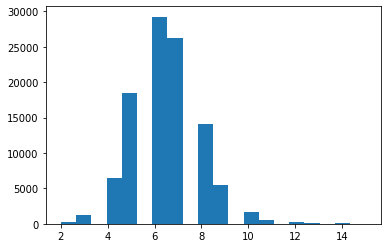

In [ ]:
names_length = [len(nom) for nom in data['Name'].values]

import matplotlib.pyplot as plt
plt.hist(names_length,bins=20)

**Fourth step: Pad variable length sequences with 0 values.**<br>
We want to make all the names list the same size using the Keras **pad_sequences** function.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(data['Name'].values,maxlen=10, padding='pre')
X[0:4]

array([[ 0,  0,  0,  0,  0, 20,  1, 21, 14, 15],
       [ 0,  0,  0,  0,  0,  2,  5, 21, 14,  1],
       [ 0,  0,  0,  0,  0, 14,  5, 22,  1, 14],
       [ 1,  3,  1, 20,  8,  5, 18,  9, 14,  5]], dtype=int32)

**Fifth step: We create the target values Y.**

In [ ]:
Y = data['Gender'].values

**Sixth step:** we split the X,Y into training set and test set using sklearn.model_selection.train_test_split.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

**Seventh step: We set up  3 differents LSTMs**
* one with a single LSTM layer
* one with 2 LSTM layers
* one with a Bidirectional LSTM
In this step, we compile and fit each model.

Here, we define a neural network with a single LSTM layer: 
* Since we use pad_sequences with a maxlen=10, the Input layer should have the shape=(10,) earlier in this example.
* The embedding layer produce outputs dense vectors with 5 components (output_dim=5)
* Units=32 in the first LSTM layer means this layer outputs a 32 sized vector.

input_dim in the Embedding Layer is the size of the vocabulary.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

vocabsize = len(vocab)+1

LSTM_SINGLE = Sequential([Input(shape=(10,)),Embedding(input_dim=vocabsize,output_dim=5),\
                          LSTM(units=40),Dense(1,activation='sigmoid')])

We compile the LSTM SINGLE model using an adam optimizer, a binary_crossentropy loss and we set metrics=['accuracy']. Then, we fit it with 20 epochs and batch_size=256.

In [ ]:
LSTM_SINGLE.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
his = LSTM_SINGLE.fit(X_train,y_train,epochs=20,batch_size=256)

Epoch 1/20
273/273 [==============================] - 6s 14ms/step - loss: 0.5869 - accuracy: 0.6842
Epoch 2/20
273/273 [==============================] - 4s 13ms/step - loss: 0.4738 - accuracy: 0.7716
Epoch 3/20
273/273 [==============================] - 4s 13ms/step - loss: 0.4647 - accuracy: 0.7788
Epoch 4/20
273/273 [==============================] - 4s 13ms/step - loss: 0.4621 - accuracy: 0.7796
Epoch 5/20
273/273 [==============================] - 4s 13ms/step - loss: 0.4604 - accuracy: 0.7803
Epoch 6/20
273/273 [==============================] - 4s 13ms/step - loss: 0.4598 - accuracy: 0.7814
Epoch 7/20
273/273 [==============================] - 4s 13ms/step - loss: 0.4575 - accuracy: 0.7817
Epoch 8/20
273/273 [==============================] - 4s 13ms/step - loss: 0.4558 - accuracy: 0.7828
Epoch 9/20
273/273 [==============================] - 4s 14ms/step - loss: 0.4538 - accuracy: 0.7848
Epoch 10/20
273/273 [==============================] - 4s 13ms/step - loss: 0.4510 - accura

Now, we evaluate LSTM SINGLE on the test set:

In [ ]:
LSTM_SINGLE.evaluate(X_test,y_test)

1074/1074 [==============================] - 4s 3ms/step - loss: 0.4396 - accuracy: 0.7937


[0.4395732581615448, 0.7936956286430359]

Now, we create a neural network with 2 LSTM layers:
* Since we use pad_sequences with a maxlen=10, the Input layer should have the shape=(10,) earlier in this example.
* The embedding layer produce outputs dense vectors with 5 components (output_dim=5)
* Units=32 in the first LSTM layer means this layer outputs a 32 sized vector. Since, we have a second LSTM layer, we should set return_sequences=True.
* Units=64 in the first LSTM layer means this layer outputs a 64 sized vector
* Since we solve a classification problem with 2 classes, the last layer is a dense layer with sigmoid activation function.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

vocabsize = len(vocab)+1

LSTM_TWO_LSTM = Sequential([Input(shape=(10,)),Embedding(input_dim=vocabsize,output_dim=5),\
                            LSTM(units=32,return_sequences=True),LSTM(units=64),\
                            Dense(1,activation='sigmoid')])

We compile the LSTM SINGLE model using an adam optimizer, a binary_crossentropy loss and we set metrics=['accuracy']. Then, we fit it with 15 epochs and batch_size=256.

In [ ]:
LSTM_TWO_LSTM.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
his = LSTM_TWO_LSTM.fit(X_train,y_train,epochs=15,batch_size=256)

Epoch 1/15
273/273 [==============================] - 14s 37ms/step - loss: 0.6159 - accuracy: 0.6568
Epoch 2/15
273/273 [==============================] - 10s 38ms/step - loss: 0.4794 - accuracy: 0.7702
Epoch 3/15
273/273 [==============================] - 10s 37ms/step - loss: 0.4666 - accuracy: 0.7783
Epoch 4/15
273/273 [==============================] - 10s 38ms/step - loss: 0.4635 - accuracy: 0.7783
Epoch 5/15
273/273 [==============================] - 10s 37ms/step - loss: 0.4608 - accuracy: 0.7798
Epoch 6/15
273/273 [==============================] - 10s 36ms/step - loss: 0.4583 - accuracy: 0.7815
Epoch 7/15
273/273 [==============================] - 10s 36ms/step - loss: 0.4558 - accuracy: 0.7826
Epoch 8/15
273/273 [==============================] - 10s 37ms/step - loss: 0.4535 - accuracy: 0.7844
Epoch 9/15
273/273 [==============================] - 10s 36ms/step - loss: 0.4516 - accuracy: 0.7858
Epoch 10/15
273/273 [==============================] - 10s 36ms/step - loss: 0.448

Here, we define a neural network with a single bidirectional LSTM layer: 
* Since we use pad_sequences with a maxlen=10, the Input layer should have the shape=(10,) earlier in this example.
* The embedding layer produce outputs dense vectors with 5 components (output_dim=5)
* Units=32 in the first LSTM layer means this layer outputs a 32 sized vector.

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Input, Embedding
from tensorflow.keras.models import Sequential

vocabsize = len(vocab)+1

NAME_BIDIRECT = Sequential([Input(shape=(10,)),Embedding(input_dim=vocabsize,output_dim=5),\
                           Bidirectional(LSTM(units=32)),Dense(1,activation='sigmoid')])

In [ ]:
NAME_BIDIRECT.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
his = NAME_BIDIRECT.fit(X_train,y_train,epochs=15,batch_size=256)

Epoch 1/15
273/273 [==============================] - 8s 17ms/step - loss: 0.5703 - accuracy: 0.7006
Epoch 2/15
273/273 [==============================] - 5s 17ms/step - loss: 0.5075 - accuracy: 0.7522
Epoch 3/15
273/273 [==============================] - 5s 17ms/step - loss: 0.4804 - accuracy: 0.7661
Epoch 4/15
273/273 [==============================] - 5s 17ms/step - loss: 0.4645 - accuracy: 0.7768
Epoch 5/15
273/273 [==============================] - 5s 17ms/step - loss: 0.4612 - accuracy: 0.7783
Epoch 6/15
273/273 [==============================] - 5s 17ms/step - loss: 0.4583 - accuracy: 0.7809
Epoch 7/15
273/273 [==============================] - 5s 18ms/step - loss: 0.4563 - accuracy: 0.7819
Epoch 8/15
273/273 [==============================] - 5s 17ms/step - loss: 0.4546 - accuracy: 0.7831
Epoch 9/15
273/273 [==============================] - 5s 17ms/step - loss: 0.4540 - accuracy: 0.7847
Epoch 10/15
273/273 [==============================] - 5s 18ms/step - loss: 0.4526 - accura

**Eighth step : we use the model LSTM_SINGLE to predict the gender of new names.**<br>
We test LSTM_SINGLE model with some new names. mmy_model.predict returns the probability of the tested name is masculine.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
def input_name_to_test(nom):
    new_nom=nom.lower()
    new_nom=[vocab[l] for l in list(new_nom)]
    new_nom=pad_sequences(np.array([new_nom]),maxlen=10, padding='pre')
    probability_masc = LSTM_SINGLE.predict(new_nom)
    if probability_masc<0.5:
        print(nom+" is probably a feminine name")
    else:
        print(nom+" is probably a masculine name")
    return(probability_masc)

input_name_to_test('Linda'), input_name_to_test('Brian'), input_name_to_test('Fabien')

Linda is probably a feminine name
Brian is probably a masculine name
Fabien is probably a masculine name


(array([[0.09184498]], dtype=float32),
 array([[0.6981571]], dtype=float32),
 array([[0.60152596]], dtype=float32))

# Exercice : Country prediction of cities
In this exercice, our goal is to predict the country of cities from France, Germany and Italy. Run, the cell below to create the database of cities names. In this database, there are 2 columns : Country, City. 

In [19]:
import pandas as pd
file = "https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/citie_fr_ge_it.csv"
world_cities_fr_ge_it = pd.read_csv(file,compression='zip')
world_cities_fr_ge_it = world_cities_fr_ge_it.loc[world_cities_fr_ge_it['Country']\
                                                  .isin(['fr','ge','it'])][['Country','City','AccentCity']]\
                                                  .drop_duplicates(subset=['Country','City','AccentCity']).reset_index()

fr = world_cities_fr_ge_it.loc[world_cities_fr_ge_it['Country']=='fr'].sample(n=20000)
ge = world_cities_fr_ge_it.loc[world_cities_fr_ge_it['Country']=='ge']
it = world_cities_fr_ge_it.loc[world_cities_fr_ge_it['Country']=='it']
world_cities_fr_ge_it = pd.concat([fr,ge,it],axis=0).sample(frac=1)[['Country','City']]
world_cities_fr_ge_it.head(5)

,Country,City
69430,it,case terranova
68252,it,cappuccini di riano
76808,it,omignano
68317,it,carbona
17150,fr,fresnay-les-chaumes


1) Remove the blanks of the City column. You can use the function below. 

In [20]:
import string
letters = list(string.ascii_lowercase)
def remove_non_lettre(ville):
    hh = list(str(ville))
    hhbis = [lettre for lettre in hh if lettre in letters]
    hhbis = "".join(hhbis)
    return(hhbis)
remove_non_lettre('saint-martin-de-bromes')

'saintmartindebromes'

In [ ]:
#Your code here : 
world_cities_fr_ge_it['City'] = #complete the code here

2) Encode the Country column using LabelEncoder from the sklearn library. Store the result in a new column named Country_encode.

In [ ]:
#your code here
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(world_cities_fr_ge_it['Country'].unique())

world_cities_fr_ge_it['Country_encode'] = #complete the code here

3) Encode the letters of cities names from the City column. Read the third step in the above example. Store the result in a new column called City_code.

In [ ]:
import string
letters = list(string.ascii_lowercase)
vocab = dict(zip(letters,range(1,27)))

def letter_to_number(nom):
    return([vocab[l] for l in list(nom)])

world_cities_fr_ge_it['City_code'] = #your code here

4) The lengths of the encoded cities names are not constant. We have to make all encoded cities names the same size. For this purpose we have to use pad_sequences from tensorflow.keras library like it is done in the fourth step in the above example. Apply pad_sequences to world_cities_fr_ge_it['City_code'] with max_len=20 and padding='pre'. Store the result in X.

In [ ]:
#your code here
from tensorflow.keras.preprocessing.sequence import pad_sequences 
X = #complete

5) In this question we create the target value Y. Remember, we have 3 classes encoded in the question 2. Create the target value Y using to_categorical from the tensorflow.keras library and world cities_fr_ge_it['Country_code'] you created in question 2. **to_categorical**  converts a class vector (integers) to binary class matrix (see the example below):

In [ ]:
from tensorflow.keras.utils import to_categorical
classe_vectore = [0, 1, 2, 3]
binary_class_matrix= to_categorical(classe_vectore,num_classes=4)
binary_class_matrix

In [ ]:
#your code here
from tensorflow.keras.utils import to_categorical

Y = #your code here

6) Create the train set and the test set from X (created in question 4) and Y (created in question 5). For this purpose apply train_test_split from the sklearn package.

In [ ]:
#your code here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = #your code here 

7) In this question we Build a model with a single LSTM layer to predict the country of a city name. Build a neural network with the following layers:
* an Input layer
* an Embedding layer that output a 6 sized vector
* a LSTM layer with 42 units
* a Dense layer

Call this model city_single. Compile this model with an adam optimizer and the accuracy metric. Fit it with 10 epochs using X_train and y_train. Evaluate this model on X_test and y_test.

In [ ]:
from tensorflow.keras.layers import Dense, BatchNormalization, LSTM, Input, Embedding
from tensorflow.keras import Sequential

vocabsize = len(vocab)+1

city_single = #your code here

8) Use city_single to predict the country of dijon, baressa, chvrnisi. 
* The function handle_city_name return the padded encoding of a city name. 
* city_single.predict return a probability vector.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def  handle_city_name(cityname):
    name = remove_non_lettre(cityname)
    name = letter_to_number(name)
    name = pad_sequences(np.array([name]),maxlen=20, padding='pre')
    return(name)

handle_city_name('dijon')

In [ ]:
city_single.predict(handle_city_name('dijon'))

In [ ]:
#your code here


9) In this question we build a model with a 2 LSTM layers to predict the country of a city name. Build a neural network with the following layers:
* an Input layer
* an Embedding layer that output a 6 sized vector
* a LSTM layer with 30 units. You have to set return_sequences=True
* a dropout layer with rate=0.2
* a LSTM layer with 60 units.
* a Dense layer

Call this model city_double. Compile this model with an adam optimizer and the accuracy metric. Fit it with 10 epochs using X_train and y_train. Evaluate this model on X_test and y_test.

In [ ]:
#your code here
from tensorflow.keras.layers import Dense, BatchNormalization, LSTM, Input, Embedding, Dropout
from tensorflow.keras import Sequential

vocabsize = len(vocab)+1

10) Build a model with a bidirectional LSTM layer to predict the country of a city. Call this model city_bidirect. Compile this model with an adam optimizer and the accuracy metric. Fit it with 10 epochs using X_train and y_train. Evaluate this model on X_test and y_test.

In [ ]:
from tensorflow.keras.layers import Dense, BatchNormalization, LSTM, Input, Embedding, Bidirectional
from tensorflow.keras import Sequential